In [2]:
import os
import json
import numpy as np
from collections import defaultdict
from scipy.spatial.transform import Rotation as R

# 디렉토리 설정
base_dirs = ["./Fr5/Fr5_ArUco"]
output_dir = "./Fr5/Fr5_correct_ArUco"
os.makedirs(output_dir, exist_ok=True)

# 파일 이름에서 뷰와 카메라 추출
def parse_filename(filename):
    parts = filename.split('_')
    view = parts[0]
    cam = parts[2]
    return view, cam

# 데이터 구조: data[view][cam][marker_id] = list of marker dicts
data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# 파일 수집 및 데이터 적재
for base_dir in base_dirs:
    if not os.path.exists(base_dir):
        continue
    for fname in os.listdir(base_dir):
        if not fname.endswith('.json'):
            continue
        view, cam = parse_filename(fname)
        with open(os.path.join(base_dir, fname), 'r') as f:
            content = json.load(f)
            for marker_id, marker_data in content.items():
                data[view][cam][marker_id].append(marker_data)

# 회전 평균 함수
def average_quaternion(quaternions):
    M = np.zeros((4, 4))
    for q in quaternions:
        q = q.reshape(4, 1)
        M += q @ q.T
    eigvals, eigvecs = np.linalg.eigh(M)
    avg_quat = eigvecs[:, np.argmax(eigvals)]
    return avg_quat / np.linalg.norm(avg_quat)

# 각도 차이(degree) 계산 함수
def angular_distance_deg(q1, q2):
    r1 = R.from_quat(q1)
    r2 = R.from_quat(q2)
    relative_rot = r1.inv() * r2
    return np.rad2deg(relative_rot.magnitude())

# 위치 평균
def average_position(positions):
    return np.mean(positions, axis=0)

# 마커 정리 및 저장
for view in data:
    for cam in data[view]:
        corrected = {}
        for marker_id, entries in data[view][cam].items():
            if len(entries) < 2:
                continue  # 최소 두 개 이상 있어야 평균

            positions = [np.array([m['position_m']['x'], m['position_m']['y'], m['position_m']['z']]) for m in entries]
            quaternions = [np.array([m['rotation_quat']['x'], m['rotation_quat']['y'],
                                     m['rotation_quat']['z'], m['rotation_quat']['w']]) for m in entries]

            # 초기 평균 계산
            avg_quat_initial = average_quaternion(np.array(quaternions))

            # outlier 제거 (5도 이상 차이)
            filtered_positions = []
            filtered_quaternions = []
            for pos, quat in zip(positions, quaternions):
                if angular_distance_deg(avg_quat_initial, quat) <= 1.0:
                    filtered_positions.append(pos)
                    filtered_quaternions.append(quat)
                else:
                    print(f"Outlier detected for marker {marker_id} in {view}_{cam}: {quat}")

            if len(filtered_positions) == 0:
                continue  # outlier 제거 후 데이터 없음

            avg_pos = average_position(filtered_positions)
            avg_quat = average_quaternion(np.array(filtered_quaternions))

            corrected[marker_id] = {
                "position_m": {"x": float(avg_pos[0]), "y": float(avg_pos[1]), "z": float(avg_pos[2])},
                "rotation_quat": {"x": float(avg_quat[0]), "y": float(avg_quat[1]),
                                  "z": float(avg_quat[2]), "w": float(avg_quat[3])},
                "corners_pixel": entries[0]["corners_pixel"]
            }

        # 저장
        output_path = os.path.join(output_dir, f"{view}_{cam}_corrected.json")
        with open(output_path, 'w') as f:
            json.dump(corrected, f, indent=4)

print(f"Corrected data saved to {output_dir}")

Outlier detected for marker 2 in right_leftcam: [-0.4983  0.4799  0.5081  0.5131]
Outlier detected for marker 4 in right_leftcam: [-0.5135  0.469   0.5039  0.5123]
Outlier detected for marker 2 in left_leftcam: [-0.4982 -0.4858 -0.512   0.5036]
Outlier detected for marker 2 in left_leftcam: [-0.4818 -0.4751 -0.5211  0.5202]
Outlier detected for marker 2 in left_leftcam: [-0.4978 -0.4859 -0.5124  0.5035]
Outlier detected for marker 2 in top_rightcam: [-0.0255 -0.0089  0.9996  0.0028]
Outlier detected for marker 2 in top_rightcam: [-0.0722 -0.0526  0.996   0.0023]
Outlier detected for marker 2 in top_rightcam: [ 0.0688  0.052  -0.9963 -0.0023]
Outlier detected for marker 2 in top_rightcam: [-0.0685 -0.0491  0.9964  0.0023]
Outlier detected for marker 5 in top_rightcam: [-4.700e-02 -1.790e-02 -9.987e-01  4.000e-04]
Outlier detected for marker 5 in top_rightcam: [-6.940e-02 -4.010e-02 -9.968e-01  8.000e-04]
Outlier detected for marker 5 in top_rightcam: [-6.990e-02 -4.090e-02 -9.967e-01  6

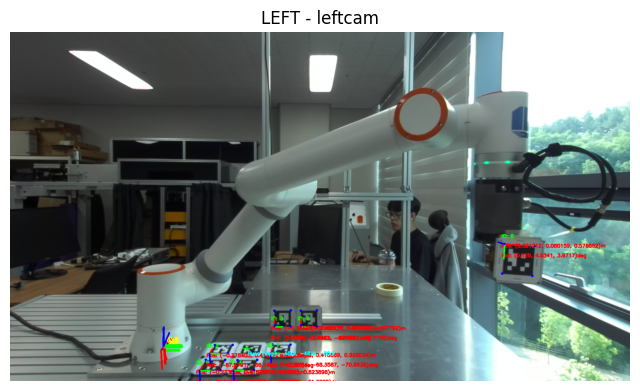

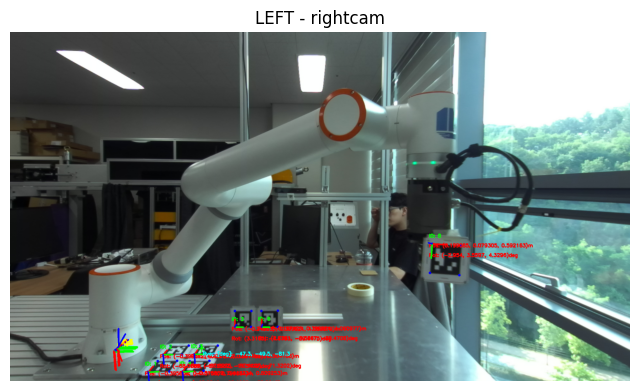

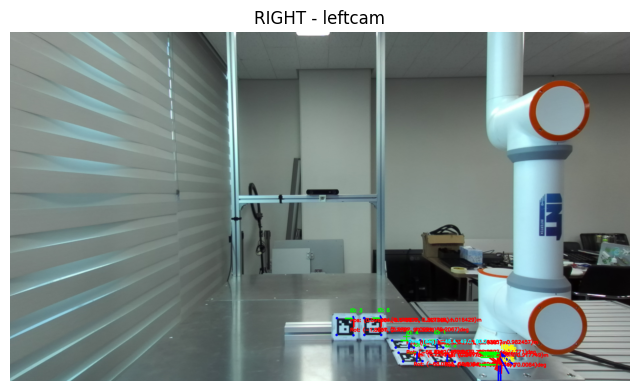

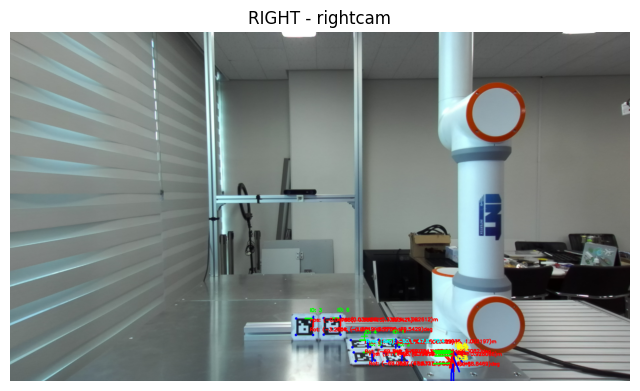

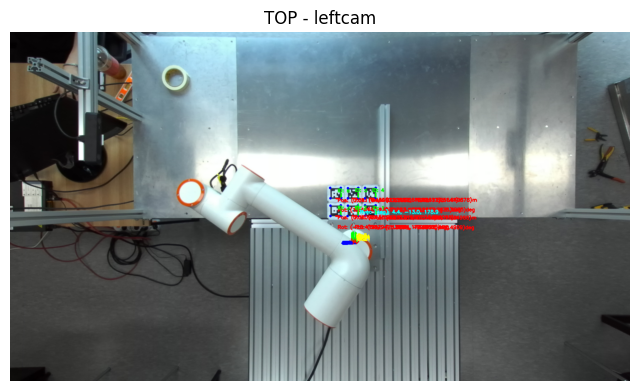

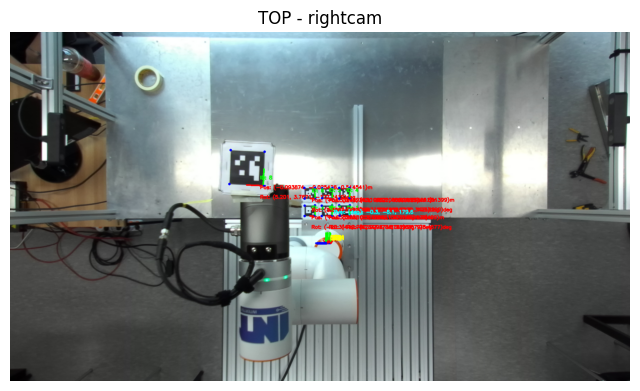

In [3]:
import os
import glob
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import pandas as pd

# -------------------- 설정 --------------------
base_dir = "./Fr5/Fr5_correct_ArUco"
image_dir = "./Fr5/Fr5_ArUco"
calib_dir = "./Fr5/Fr5_calib_cam_from_conf"
views = ['left', 'right', 'top']
cams = ['leftcam', 'rightcam']

# 시리얼 ↔ 위치 맵
camera_serials = {"right": 34850673, "left": 38007749, "top": 30779426}

# 마커 오프셋 (m)
marker_offsets = {
    "left": {
        "1": np.array([0.095, -0.135, -0.0065]), "2": np.array([0.025, -0.135, -0.0065]), "3": np.array([-0.01, -0.295, -0.12]),
        "4": np.array([0.095, -0.215, -0.0065]), "5": np.array([0.025, -0.215, -0.0065]), "6": np.array([-0.01, -0.375, -0.12]),
    },
    "right": {
        "1": np.array([0.095, -0.135, -0.0065]), "2": np.array([0.025, -0.135, -0.0065]), "3": np.array([0.09, -0.375, -0.12]),
        "4": np.array([0.095, -0.215, -0.0065]), "5": np.array([0.025, -0.215, -0.0065]), "6": np.array([0.09, -0.295, -0.12]),
    },
    "top": {
        "1": np.array([0.095, -0.135, 0]), "2": np.array([0.025, -0.135, 0]), "3": np.array([-0.055, -0.135, 0]),
        "4": np.array([0.095, -0.215, 0]), "5": np.array([0.025, -0.215, 0]), "6": np.array([-0.055, -0.215, 0]),
    }
}

# -------------------- 결과 저장용 --------------------
summary = []
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale_axis = 0.3
font_scale_marker = 0.6
thickness_axis = 2
thickness_marker = 2

for view in views:
    serial = camera_serials[view]
    for cam in cams:
        pose_path = os.path.join(base_dir, f"{view}_{cam}_corrected.json")
        calib_path = os.path.join(calib_dir, f"{view}_{serial}_{cam}_calib.json")

        if not (os.path.exists(pose_path) and os.path.exists(calib_path)):
            continue

        with open(pose_path) as f:
            poses = json.load(f)
        with open(calib_path) as f:
            calib = json.load(f)

        K = np.array(calib["camera_matrix"], dtype=np.float64)
        dist = np.array(calib["distortion_coeffs"], dtype=np.float64)

        # 마커별 좌표 리스트 생성
        pts_world = [(mid, np.array([p["position_m"]["x"], p["position_m"]["y"], p["position_m"]["z"]]))
                     for mid, p in poses.items() if mid in marker_offsets[view]]

        if not pts_world:
            continue

        base_positions = np.vstack([b for _, b in pts_world])
        mean_base = base_positions.mean(axis=0)
        std_base = base_positions.std(axis=0)

        # tvec, rvec 계산 (오프셋 적용 후)
        tvecs, rvecs, marker_ids = [], [], []
        for mid, offset in marker_offsets[view].items():
            if mid not in poses or mid == "8":
                continue
            p = poses[mid]
            tvec = np.array([p["position_m"]["x"], p["position_m"]["y"], p["position_m"]["z"]])
            quat = np.array([p["rotation_quat"][k] for k in ("x", "y", "z", "w")])
            rvec = R.from_quat(quat).as_rotvec()
            Rm = R.from_quat(quat).as_matrix()
            tvec_with_offset = tvec + Rm.dot(offset)
            tvecs.append(tvec_with_offset)
            rvecs.append(rvec)
            marker_ids.append(mid)

        if not tvecs:
            continue

        # 기준 마커를 통한 평균 회전 계산
        ref_mid = min((mid for mid in marker_offsets[view] if mid in poses and mid != "8"),
                      key=lambda m: np.linalg.norm(marker_offsets[view][m]))
        ref_quat = np.array([poses[ref_mid]["rotation_quat"][k] for k in ("x", "y", "z", "w")])
        R_ref = R.from_quat(ref_quat).as_matrix()

        R_all = [R_ref.T @ R.from_quat(np.array([poses[mid]["rotation_quat"][k] for k in ("x", "y", "z", "w")])).as_matrix()
                 for mid in marker_ids]

        R_all_stack = np.stack(R_all)
        R_mean_relative = R.from_matrix(R_all_stack).mean()
        R_mean_global = R.from_matrix(R_ref @ R_mean_relative.as_matrix())
        mean_rvec = R_mean_global.as_rotvec()
        mean_tvec = np.mean(tvecs, axis=0)

        # 이미지 로드
        img_files = glob.glob(os.path.join(image_dir, f"{view}_*_{cam}_*.png"))
        if not img_files:
            continue
        img = cv2.imread(img_files[0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 마커별 좌표축 및 ID 표시
        for idx, (rvec, tvec, mid) in enumerate(zip(rvecs, tvecs, marker_ids)):
            cv2.drawFrameAxes(img, K, dist, rvec, tvec.reshape(3, 1), 0.05)
            marker_pos_2d, _ = cv2.projectPoints(tvec.reshape(1, 3), np.zeros((3, 1)), np.zeros((3, 1)), K, dist)
            x_marker, y_marker = marker_pos_2d.ravel().astype(int)
            offset_text = (x_marker + 10, y_marker - 10)  # 텍스트 위치 조정
            cv2.putText(img, f"ID:{mid}", offset_text, font, font_scale_marker, (255, 255, 0), thickness_marker)

        # 평균 좌표계 시각화
        cv2.drawFrameAxes(img, K, dist, mean_rvec.reshape(3, 1), mean_tvec.reshape(3, 1), 0.05)
        mean_base_3d = mean_base.reshape(1, 1, 3)
        mb2, _ = cv2.projectPoints(mean_base_3d, np.zeros((3, 1)), np.zeros((3, 1)), K, dist)
        xm, ym = mb2.ravel().astype(int)
        summary.append([view, cam, *mean_base, *std_base, xm, ym, *mean_tvec, *mean_rvec])

        cv2.drawMarker(img, (xm, ym), (0, 255, 0), cv2.MARKER_CROSS, 20, 2)
        mean_rvec_deg = np.rad2deg(mean_rvec)
        rvec_text = f"Rvec [deg]: {mean_rvec_deg[0]:.1f}, {mean_rvec_deg[1]:.1f}, {mean_rvec_deg[2]:.1f}"
        cv2.putText(img, rvec_text, (xm + 5, ym + 20), font, 0.5, (0, 255, 255), 2)

        # 시각화
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{view.upper()} - {cam}")
        plt.show()

# -------------------- 결과 저장 --------------------
columns = ["view", "cam", "mean_x", "mean_y", "mean_z",
           "std_x", "std_y", "std_z", "proj_x", "proj_y",
           "tvec_x", "tvec_y", "tvec_z",
           "rvec_x", "rvec_y", "rvec_z"]
df = pd.DataFrame(summary, columns=columns)

output_dir = "./Fr5/Fr5_aruco_pose_summary"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "aruco_pose_summary.json")
df.to_json(output_path, orient="records", indent=2)

In [1]:
import os
import json
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# ---------------------- ArUco 결과 및 데이터 경로 ----------------------
aruco_path = '/home/najo/NAS/DIP/Intertek_Zed_ArUco_Calibration/ArUco_result_output/fr5_aruco_pose_summary.json'
with open(aruco_path, 'r') as f:
    aruco_results_all = json.load(f)

image_paths = [
    "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_6th_250526/left/zed_38007749_left_1748249285.128.jpg",
    "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_6th_250526/right/zed_34850673_left_1748249285.134.jpg",
    "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_6th_250526/top/zed_30779426_left_1748249285.123.jpg"
]
joint_data_path = "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_6th_250526/joint/joint_30779426_1748249285.123.json"

# ---------------------- 조인트 데이터 로드 ----------------------
with open(joint_data_path, 'r') as f:
    joint_angles = json.load(f)

# ---------------------- DH 변환 행렬 계산 함수 ----------------------
def get_dh_matrix(a, d, alpha, theta):
    alpha_rad = math.radians(alpha)
    theta_rad = math.radians(theta)
    return np.array([
        [np.cos(theta_rad), -np.sin(theta_rad) * np.cos(alpha_rad),  np.sin(theta_rad) * np.sin(alpha_rad), a * np.cos(theta_rad)],
        [np.sin(theta_rad),  np.cos(theta_rad) * np.cos(alpha_rad), -np.cos(theta_rad) * np.sin(alpha_rad), a * np.sin(theta_rad)],
        [0, np.sin(alpha_rad), np.cos(alpha_rad), d],
        [0, 0, 0, 1]
    ])

# ---------------------- 조인트 각도를 카메라 좌표계 내 조인트 위치로 변환 ----------------------
def angle_to_joint_coordinate(joint_angles, selected_view):
    # FR5 DH parameters (degrees and meters)
    fr5_dh_parameters = [
        {'alpha': 90,  'a': 0,     'd': 0.152, 'theta': 0},
        {'alpha': 0,   'a': -0.425,'d': 0,     'theta': 0},
        {'alpha': 0,   'a': -0.395,'d': 0,     'theta': 0},
        {'alpha': 90,  'a': 0,     'd': 0.102, 'theta': 0},
        {'alpha': -90, 'a': 0,     'd': 0.102, 'theta': 0},
        {'alpha': 0,   'a': 0,     'd': 0.100, 'theta': 0}
    ]
    joint_coords_3d = [np.array([0, 0, 0])] # J0 (베이스)

    # 카메라 뷰에 따른 베이스 좌표계 보정 회전 정의
    view_rotations = {
        'top': R.from_euler('zyx', [-88, 0, 180], degrees=True),
        'left': R.from_euler('zyx', [180, 0, 92], degrees=True),
        'right': R.from_euler('zyx', [0, 0, 95], degrees=True)
    }
    
    T_base_correction = np.eye(4)
    if selected_view in view_rotations:
        T_base_correction[:3, :3] = view_rotations[selected_view].as_matrix()

    T_cumulative = T_base_correction
    base_point = np.array([[0], [0], [0], [1]])
    for i in range(6):
        params = fr5_dh_parameters[i]
        theta = joint_angles[i] + params['theta']
        T_i = get_dh_matrix(params['a'], params['d'], params['alpha'], theta)
        T_cumulative = T_cumulative @ T_i
        joint_pos = T_cumulative @ base_point
        joint_coords_3d.append(joint_pos[:3, 0])
    return np.array(joint_coords_3d, dtype=np.float32)

# ---------------------- 3D 조인트 좌표를 이미지 평면에 투영 ----------------------
def joint_coordinate_to_pixel_plane(joint_coords, aruco_result, camera_matrix, dist_coeffs):
    Rvec = np.array([
        math.radians(aruco_result['rvec_x']),
        math.radians(aruco_result['rvec_y']),
        math.radians(aruco_result['rvec_z'])
    ], dtype=np.float32)
    Tvec = np.array([
        aruco_result['tvec_x'],
        aruco_result['tvec_y'],
        aruco_result['tvec_z']
    ], dtype=np.float32).reshape(3, 1)

    pixel_coords, _ = cv2.projectPoints(
        joint_coords, Rvec, Tvec, camera_matrix, dist_coeffs
    )
    return pixel_coords.reshape(-1, 2)

# ---------------------- 개별 뷰를 처리하고 플롯하는 함수 ----------------------
def plot_view(image_path, joint_angles, aruco_results_all):
    image_name = os.path.basename(image_path)
    parts = image_name.split('_')

    serial_str = parts[1]
    serial_to_view = {
        "38007749": "left",
        "34850673": "right",
        "30779426": "top"
    }
    selected_view = serial_to_view[serial_str]
    selected_cam = parts[2] + "cam"

    aruco_result = next(
        item for item in aruco_results_all 
        if item['view'] == selected_view and item['cam'] == selected_cam
    )

    camera_serials = {"top": 30779426, "right": 34850673, "left": 38007749}
    calib_dir = "./Calib_cam_from_conf"
    serial = camera_serials[selected_view]
    calib_path = os.path.join(calib_dir, f"{selected_view}_{serial}_{selected_cam}_calib.json")

    with open(calib_path, 'r') as f:
        calib = json.load(f)

    camera_matrix = np.array(calib["camera_matrix"], dtype=np.float32)
    dist_coeffs = np.array(calib["distortion_coeffs"], dtype=np.float32)

    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    undistorted = cv2.undistort(image_rgb, camera_matrix, dist_coeffs)

    joint_coords = angle_to_joint_coordinate(joint_angles, selected_view)
    pixel_coords = joint_coordinate_to_pixel_plane(joint_coords, aruco_result, camera_matrix, dist_coeffs)

    aruco_axis_length = 0.1
    aruco_axis_points = np.array([
        [0, 0, 0],
        [aruco_axis_length, 0, 0],
        [0, aruco_axis_length, 0],
        [0, 0, aruco_axis_length]
    ], dtype=np.float32)

    Rvec = np.array([
        math.radians(aruco_result['rvec_x']),
        math.radians(aruco_result['rvec_y']),
        math.radians(aruco_result['rvec_z'])
    ], dtype=np.float32)
    Tvec = np.array([
        aruco_result['tvec_x'],
        aruco_result['tvec_y'],
        aruco_result['tvec_z']
    ], dtype=np.float32).reshape(3, 1)

    projected_axes, _ = cv2.projectPoints(
        aruco_axis_points, Rvec, Tvec, camera_matrix, dist_coeffs
    )
    projected_axes = projected_axes.reshape(-1, 2).astype(int)

    origin_aruco = tuple(projected_axes[0])
    x_end_aruco = tuple(projected_axes[1])
    y_end_aruco = tuple(projected_axes[2])
    z_end_aruco = tuple(projected_axes[3])

    image_with_axes = undistorted.copy()
    cv2.arrowedLine(image_with_axes, origin_aruco, x_end_aruco, (255, 0, 0), 3) # X - Red
    cv2.arrowedLine(image_with_axes, origin_aruco, y_end_aruco, (0, 255, 0), 3) # Y - Green
    cv2.arrowedLine(image_with_axes, origin_aruco, z_end_aruco, (0, 0, 255), 3) # Z - Blue

    font = cv2.FONT_HERSHEY_SIMPLEX
    for idx, (x, y) in enumerate(pixel_coords.astype(int)):
        text = f"J{idx}"
        cv2.circle(image_with_axes, (x, y), 8, (255, 0, 255), -1)
        cv2.putText(image_with_axes, text, (x + 10, y - 10), font, 1.5, (255, 0, 255), 3)
        
        if idx > 0:
            prev_x, prev_y = pixel_coords[idx-1].astype(int)
            cv2.line(image_with_axes, (prev_x, prev_y), (x, y), (255, 0, 255), 4)

    return image_with_axes, selected_view

# ---------------------- 메인 실행부 ----------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for i, image_path in enumerate(image_paths):
    try:
        image_with_axes, selected_view = plot_view(image_path, joint_angles, aruco_results_all)
        ax = axes[i]
        ax.imshow(image_with_axes)
        ax.axis("off")
        ax.set_title(f"Projected Joints for {selected_view.upper()} View", fontsize=16)
    except FileNotFoundError as e:
        print(e)
        axes[i].set_title(f"Image not found for view {selected_view}", fontsize=12)
        axes[i].axis("off")

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_6th_250526/joint/joint_30779426_1748249285.123.json'